In [4]:

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the CSV files
# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read in the data from the CSV files
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)
mouse_metadata.head(), study_results.head()
    

(  Mouse ID Drug Regimen     Sex  Age_months  Weight (g)
 0     k403     Ramicane    Male          21          16
 1     s185    Capomulin  Female           3          17
 2     x401    Capomulin  Female          16          15
 3     m601    Capomulin    Male          22          17
 4     g791     Ramicane    Male          11          16,
   Mouse ID  Timepoint  Tumor Volume (mm3)  Metastatic Sites
 0     b128          0                45.0                 0
 1     f932          0                45.0                 0
 2     g107          0                45.0                 0
 3     a457          0                45.0                 0
 4     c819          0                45.0                 0)

In [5]:

# Merge the mouse_metadata and study_results DataFrames on 'Mouse ID'
merged_df = pd.merge(study_results, mouse_metadata, on="Mouse ID")

# Display the number of unique mice IDs in the merged data
unique_mice_count = merged_df["Mouse ID"].nunique()

# Check for any mouse ID with duplicate time points
duplicate_timepoints = merged_df[merged_df.duplicated(subset=["Mouse ID", "Timepoint"], keep=False)]

# Remove duplicate data for any duplicate mouse IDs
cleaned_df = merged_df.drop_duplicates(subset=["Mouse ID", "Timepoint"])

# Display the updated number of unique mice IDs in the cleaned data
updated_unique_mice_count = cleaned_df["Mouse ID"].nunique()
unique_mice_count, duplicate_timepoints, updated_unique_mice_count
    

(249,
     Mouse ID  Timepoint  Tumor Volume (mm3)  Metastatic Sites Drug Regimen  \
 860     g989          0           45.000000                 0     Propriva   
 861     g989          0           45.000000                 0     Propriva   
 862     g989          5           48.786801                 0     Propriva   
 863     g989          5           47.570392                 0     Propriva   
 864     g989         10           51.745156                 0     Propriva   
 865     g989         10           49.880528                 0     Propriva   
 866     g989         15           51.325852                 1     Propriva   
 867     g989         15           53.442020                 0     Propriva   
 868     g989         20           55.326122                 1     Propriva   
 869     g989         20           54.657650                 1     Propriva   
 
         Sex  Age_months  Weight (g)  
 860  Female          21          26  
 861  Female          21          26  
 862  

In [6]:

# Generate summary statistics for each drug regimen
summary_statistics = cleaned_df.groupby("Drug Regimen")["Tumor Volume (mm3)"].agg(
    Mean="mean",
    Median="median",
    Variance="var",
    Standard_Deviation="std",
    SEM="sem"
).reset_index()

# Display the summary statistics DataFrame
summary_statistics
    

,Drug Regimen,Mean,Median,Variance,Standard_Deviation,SEM
0,Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
1,Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
2,Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
3,Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
4,Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
5,Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
6,Propriva,52.393463,50.909965,43.138803,6.568014,0.525862
7,Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
8,Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111
9,Zoniferol,53.236507,51.818479,48.533355,6.966589,0.516398


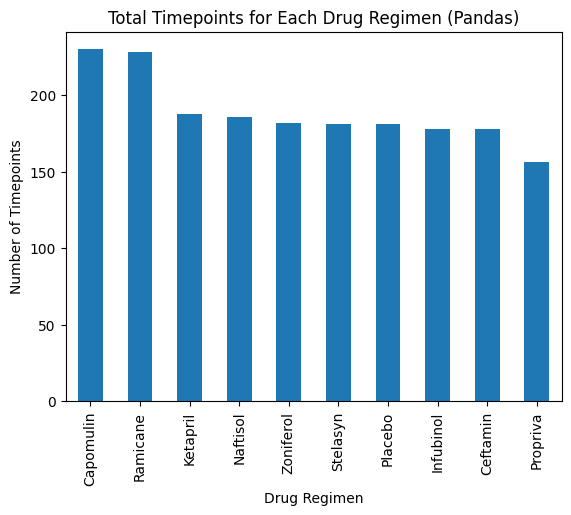

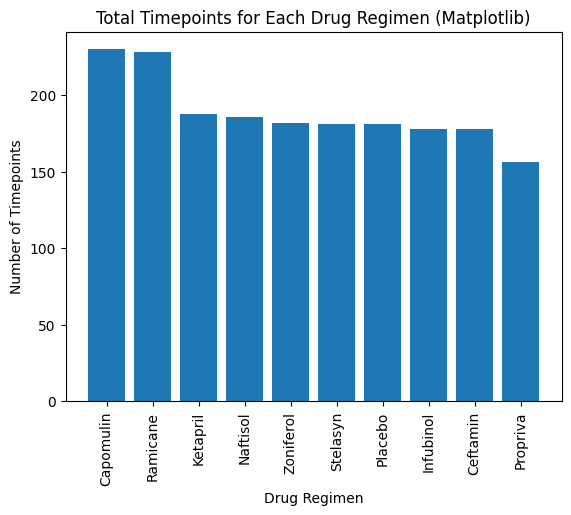

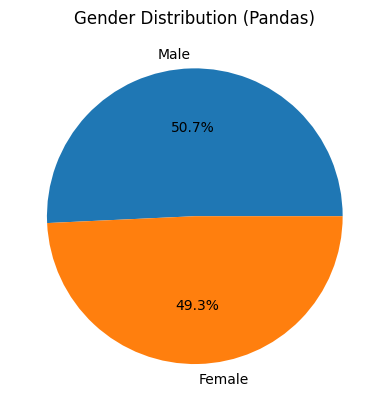

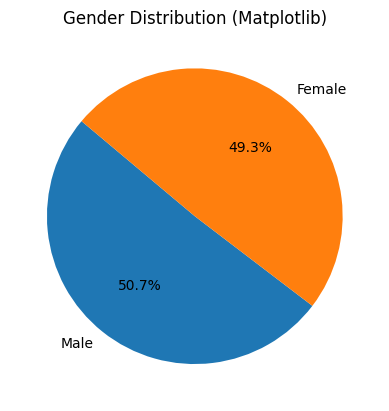

In [7]:

# Total count of Mouse ID/Timepoints for each drug regimen for bar charts
timepoint_counts = cleaned_df["Drug Regimen"].value_counts()

# Bar chart using Pandas DataFrame.plot() method
timepoint_counts.plot(kind="bar", title="Total Timepoints for Each Drug Regimen (Pandas)", xlabel="Drug Regimen", ylabel="Number of Timepoints")
plt.show()

# Bar chart using Matplotlib's pyplot
plt.bar(timepoint_counts.index, timepoint_counts.values)
plt.title("Total Timepoints for Each Drug Regimen (Matplotlib)")
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Timepoints")
plt.xticks(rotation=90)
plt.show()

# Gender distribution for pie charts
gender_counts = cleaned_df["Sex"].value_counts()

# Pie chart using Pandas DataFrame.plot() method
gender_counts.plot(kind="pie", autopct="%1.1f%%", title="Gender Distribution (Pandas)", ylabel="")
plt.show()

# Pie chart using Matplotlib's pyplot
plt.pie(gender_counts, labels=gender_counts.index, autopct="%1.1f%%", startangle=140)
plt.title("Gender Distribution (Matplotlib)")
plt.show()
    

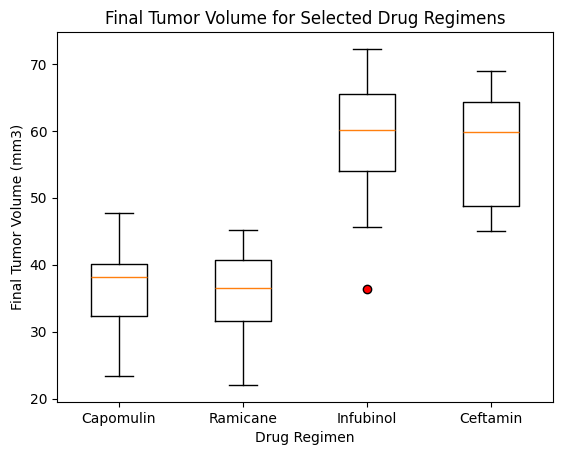

{'Capomulin': Series([], Name: Tumor Volume (mm3), dtype: float64),
 'Ramicane': Series([], Name: Tumor Volume (mm3), dtype: float64),
 'Infubinol': 31    36.321346
 Name: Tumor Volume (mm3), dtype: float64,
 'Ceftamin': Series([], Name: Tumor Volume (mm3), dtype: float64)}

In [8]:
# Quartiles, Outliers, and Boxplots 
# Calculate final tumor volume for each mouse in the top regimens
top_regimens = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]

# Get the last timepoint for each mouse and merge it with the cleaned DataFrame
last_timepoints = cleaned_df.groupby("Mouse ID")["Timepoint"].max().reset_index()
merged_last_df = pd.merge(last_timepoints, cleaned_df, on=["Mouse ID", "Timepoint"])

# Extract final tumor volumes for each treatment in top_regimens
tumor_volumes = []
for regimen in top_regimens:
    final_volumes = merged_last_df[merged_last_df["Drug Regimen"] == regimen]["Tumor Volume (mm3)"]
    tumor_volumes.append(final_volumes)

# Calculate IQR and identify outliers
outliers_info = {}
for regimen, volumes in zip(top_regimens, tumor_volumes):
    q1 = volumes.quantile(0.25)
    q3 = volumes.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = volumes[(volumes < lower_bound) | (volumes > upper_bound)]
    outliers_info[regimen] = outliers

# Generate a box plot for the final tumor volume across the top regimens
plt.boxplot(tumor_volumes, labels=top_regimens, flierprops=dict(markerfacecolor='r', marker='o'))
plt.title("Final Tumor Volume for Selected Drug Regimens")
plt.xlabel("Drug Regimen")
plt.ylabel("Final Tumor Volume (mm3)")
plt.show()

outliers_info
    

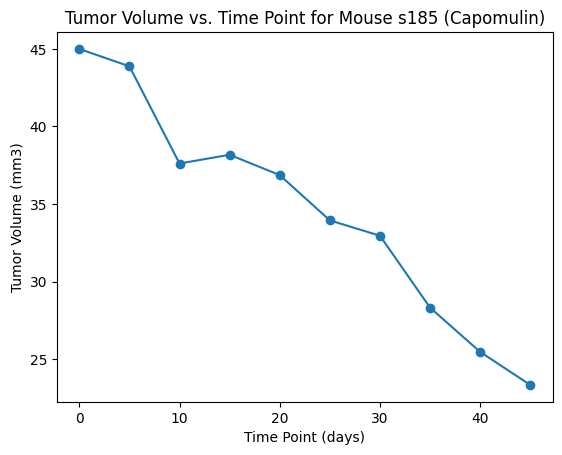

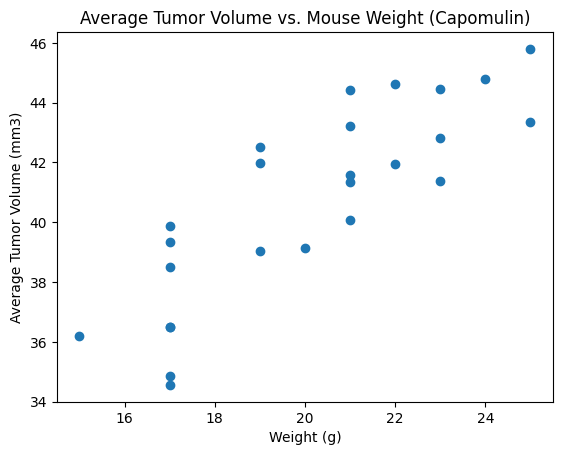

In [9]:
# Line and Scatter Plots
# Select a single mouse treated with Capomulin for the line plot
capomulin_mouse = cleaned_df[(cleaned_df["Drug Regimen"] == "Capomulin") & (cleaned_df["Mouse ID"] == "s185")]
plt.plot(capomulin_mouse["Timepoint"], capomulin_mouse["Tumor Volume (mm3)"], marker="o")
plt.title("Tumor Volume vs. Time Point for Mouse s185 (Capomulin)")
plt.xlabel("Time Point (days)")
plt.ylabel("Tumor Volume (mm3)")
plt.show()

# Scatter plot of mouse weight vs. average tumor volume for Capomulin regimen
capomulin_data = cleaned_df[cleaned_df["Drug Regimen"] == "Capomulin"]
avg_tumor_volume = capomulin_data.groupby("Mouse ID").mean(numeric_only=True)["Tumor Volume (mm3)"]
mouse_weights = capomulin_data.groupby("Mouse ID").mean(numeric_only=True)["Weight (g)"]
plt.scatter(mouse_weights, avg_tumor_volume)
plt.title("Average Tumor Volume vs. Mouse Weight (Capomulin)")
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.show()
    

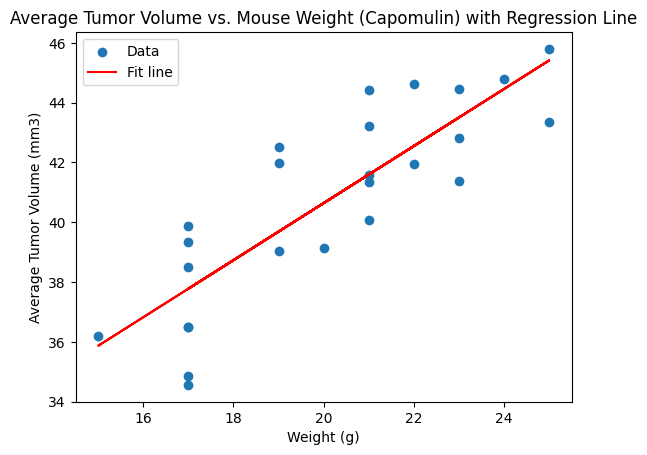

0.841936342469472

In [10]:
# Correlation and Regression
# Calculate the correlation coefficient and linear regression for Capomulin regimen
slope, intercept, r_value, p_value, std_err = linregress(mouse_weights, avg_tumor_volume)

# Plotting scatter plot with linear regression line
plt.scatter(mouse_weights, avg_tumor_volume, label="Data")
plt.plot(mouse_weights, slope * mouse_weights + intercept, color="red", label="Fit line")
plt.title("Average Tumor Volume vs. Mouse Weight (Capomulin) with Regression Line")
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.legend()
plt.show()

# Display correlation coefficient
r_value
    